# Jornada Basin Watershed


In [1]:
watershed = 'JornadaBasin'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/14-Jornada'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### Streamflow

In [4]:
# 1. streamflow data from USGS 
# USGS 08362500 RIO GRANDE BLW CABALLO DAM, NM
# Not good data? Near the dam
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=08362500&referred_module=sw&period=&begin_date=1983-01-01&end_date=2019-07-21',
                    header = 0,skiprows = 27,parse_dates = True,sep = '\t', infer_datetime_format = True)
data.head()

agency_cd   site_no    datetime 99955_00060_00003 99955_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  08362500  1983-01-01              1.20                    A
2      USGS  08362500  1983-01-02              1.20                    A
3      USGS  08362500  1983-01-03              1.10                    A
4      USGS  08362500  1983-01-04              1.10                    A

In [5]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['99955_00060_00003']))
#prep = copy.deepcopy(data[['nt.dis','bl.dis','bu.dis']])
prep.columns = ['RioGrande_Discharge']
prep1 = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)

RioGrande_Discharge
datetime                       
1983-01-01                  1.2
1983-01-02                  1.2
1983-01-03                  1.1

RioGrande_Discharge
datetime                       
2013-12-28                 1.17
2013-12-29                 1.18
2013-12-30                 1.18

In [6]:
# 2. streamflow data from USGS 
# USGS 08480595 SALT CREEK NEAR TULAROSA, NM
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?referred_module=sw&format=rdb&site_no=08480595&period=&begin_date=1995-08-31&end_date=2019-08-31',
                    header = 0,skiprows = 28,parse_dates = True,sep = '\t', infer_datetime_format = True)
data.head()

agency_cd   site_no    datetime 100068_00060_00003 100068_00060_00003_cd
0        5s       15s         20d                14n                   10s
1      USGS  08480595  1995-08-31               20.0                     A
2      USGS  08480595  1995-09-01               0.69                     A
3      USGS  08480595  1995-09-02               0.18                     A
4      USGS  08480595  1995-09-03               0.13                     A

In [7]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['100068_00060_00003']))
#prep = copy.deepcopy(data[['nt.dis','bl.dis','bu.dis']])
prep.columns = ['SaltCreek_Discharge']
prep2 = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)

SaltCreek_Discharge
datetime                       
1995-08-31                20.00
1995-09-01                 0.69
1995-09-02                 0.18

SaltCreek_Discharge
datetime                       
2019-08-29                 0.04
2019-08-30                 0.04
2019-08-31                 0.03

In [8]:
# 3. streamflow data from USGS 
# USGS 08480595 SALT CREEK NEAR TULAROSA, NM
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=08481500&referred_module=sw&period=&begin_date=1983-01-01&end_date=2019-12-31',
                    header = 0,skiprows = 28,parse_dates = True,sep = '\t', infer_datetime_format = True)
data.head()

agency_cd   site_no    datetime 100069_00060_00003 100069_00060_00003_cd
0        5s       15s         20d                14n                   10s
1      USGS  08481500  1983-01-01               14.0                     A
2      USGS  08481500  1983-01-02               13.0                     A
3      USGS  08481500  1983-01-03               13.0                     A
4      USGS  08481500  1983-01-04               12.0                     A

In [9]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['100069_00060_00003']))
prep.columns = ['TularosaCreek_Discharge']
prep3 = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)

TularosaCreek_Discharge
datetime                           
1983-01-01                     14.0
1983-01-02                     13.0
1983-01-03                     13.0

TularosaCreek_Discharge
datetime                           
2019-12-29                     12.8
2019-12-30                     12.8
2019-12-31                     13.0

In [10]:
#prep = copy.deepcopy(prep1.join(prep2,how ='outer'))
#prep = copy.deepcopy(prep.join(prep3,how ='outer'))
#prep.head()
prep = copy.deepcopy(prep2)

SaltCreek_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

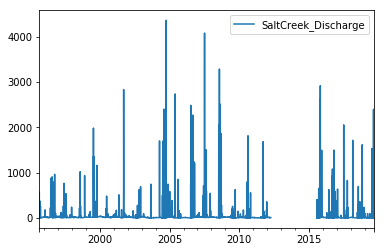

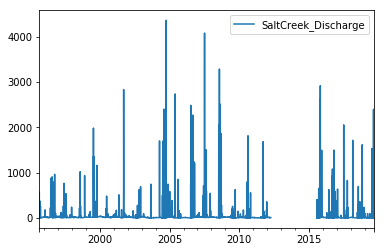

In [11]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*28.3168 # convert to the right unit(m3/s to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### Hydrometeorology

### 2. Precipitation

In [12]:
data = pd.read_csv('https://jornada.nmsu.edu/sites/jornada.nmsu.edu/files/data_files/JornadaStudy_126_lter_weather_station_climate_daily_data_0.csv',
                    header = 0,parse_dates = True,index_col = 'Date',infer_datetime_format = True,skiprows=50)
data.head(5)

MaxAirTemp  MinAirTemp  AvgAirTemp  Solar  Ppt  MaxRH  MinRH  \
Date                                                                       
1983-03-01      -99.00      -99.00      -99.00  -9.00  0.0   -9.0   -9.0   
1983-03-02        2.90       -2.00        0.31  -9.00  0.0   -9.0   -9.0   
1983-03-03      -99.00      -99.00      -99.00  -9.00  0.0   -9.0   -9.0   
1983-03-04       11.19        6.25        8.62  -9.00  0.0   -9.0   -9.0   
1983-03-05       13.94        5.06        8.91  19.97  0.0   64.6   27.8   

            VcWndMg  VcWndDir  AvgWndSpd  ...  QPpt  QMaxRH  QMinRH  QVcWndMg  \
Date                                      ...                                   
1983-03-01     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-02     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-03     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-04     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-05     -9.0        91       10.1  ...     E       G       G         M   

            QVcWndDir  QAvgWndSpd QMaxWndSpd QAvg5cmSoil QAvg20cmSoil  \
Date                                                                    
1983-03-01          M           M          M           M            M   
1983-03-02          M           M          M           M            M   
1983-03-03          M           M          M           M            M   
1983-03-04          M           M          M           M            M   
1983-03-05          G           G          G           M            M   

           QDewPoint  
Date                  
1983-03-01         M  
1983-03-02         M  
1983-03-03         M  
1983-03-04         M  
1983-03-05         M  

[5 rows x 31 columns]

In [13]:
prep = copy.deepcopy(data[['Ppt']])
prep = threC(prep,'Precipitation')
prep.columns=['JWSTA_Precipitation'] 

JWSTA_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

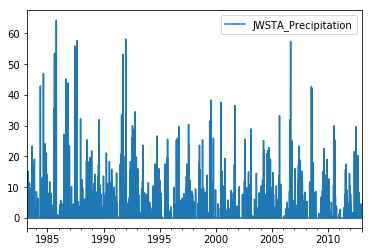

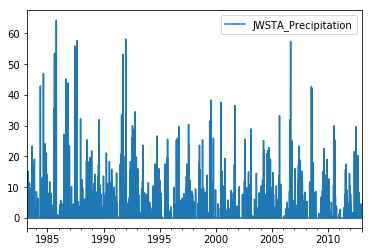

In [14]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature

In [15]:
 # Daily mean air temperature is wanted
data = pd.read_csv('https://jornada.nmsu.edu/sites/jornada.nmsu.edu/files/data_files/JornadaStudy_126_lter_weather_station_climate_daily_data_0.csv',
                    header = 0,parse_dates = True,index_col = 'Date',infer_datetime_format = True,skiprows=50)
data.head(5)

MaxAirTemp  MinAirTemp  AvgAirTemp  Solar  Ppt  MaxRH  MinRH  \
Date                                                                       
1983-03-01      -99.00      -99.00      -99.00  -9.00  0.0   -9.0   -9.0   
1983-03-02        2.90       -2.00        0.31  -9.00  0.0   -9.0   -9.0   
1983-03-03      -99.00      -99.00      -99.00  -9.00  0.0   -9.0   -9.0   
1983-03-04       11.19        6.25        8.62  -9.00  0.0   -9.0   -9.0   
1983-03-05       13.94        5.06        8.91  19.97  0.0   64.6   27.8   

            VcWndMg  VcWndDir  AvgWndSpd  ...  QPpt  QMaxRH  QMinRH  QVcWndMg  \
Date                                      ...                                   
1983-03-01     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-02     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-03     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-04     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-05     -9.0        91       10.1  ...     E       G       G         M   

            QVcWndDir  QAvgWndSpd QMaxWndSpd QAvg5cmSoil QAvg20cmSoil  \
Date                                                                    
1983-03-01          M           M          M           M            M   
1983-03-02          M           M          M           M            M   
1983-03-03          M           M          M           M            M   
1983-03-04          M           M          M           M            M   
1983-03-05          G           G          G           M            M   

           QDewPoint  
Date                  
1983-03-01         M  
1983-03-02         M  
1983-03-03         M  
1983-03-04         M  
1983-03-05         M  

[5 rows x 31 columns]

In [16]:
prep = copy.deepcopy(data[['AvgAirTemp']])
prep = threC(prep,'AirTemperature')
ready_columns =  ['JWSTA_AirTemperature'] 

AvgAirTemp


JWSTA_AirTemperature
1983-03-01                   NaN
1983-03-02                  0.31
1983-03-03                   NaN
1983-03-04                  8.62
1983-03-05                  8.91

<Figure size 720x288 with 0 Axes>

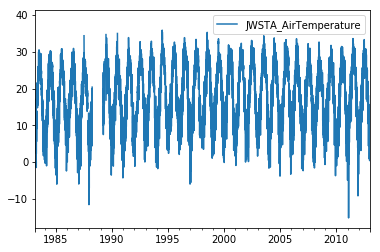

In [17]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
siteList = pd.unique(prep.columns) #siteList = pd.unique(prep['SiteName'])   ## change


nan_values = np.nan*np.ones([len(indexUnique),len(siteList)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(siteList)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site] #tab = prep[prep['SiteName'] == site]   ## change
    
    for j in np.arange(len(tab)):  
        if  data['QAvgAirTemp'][tab.index[j]] =='G':   #only keep the data when Quality is good
            df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()
AirTemperature.head()

### 4. SolarRadiation

In [18]:
data = pd.read_csv('https://jornada.nmsu.edu/sites/jornada.nmsu.edu/files/data_files/JornadaStudy_126_lter_weather_station_climate_daily_data_0.csv',
                    header = 0,parse_dates = True,index_col = 'Date',infer_datetime_format = True,skiprows=50)
data.head(3)

MaxAirTemp  MinAirTemp  AvgAirTemp  Solar  Ppt  MaxRH  MinRH  \
Date                                                                       
1983-03-01       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   
1983-03-02         2.9        -2.0        0.31   -9.0  0.0   -9.0   -9.0   
1983-03-03       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   

            VcWndMg  VcWndDir  AvgWndSpd  ...  QPpt  QMaxRH  QMinRH  QVcWndMg  \
Date                                      ...                                   
1983-03-01     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-02     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-03     -9.0        -9       -9.0  ...     G       M       M         M   

            QVcWndDir  QAvgWndSpd QMaxWndSpd QAvg5cmSoil QAvg20cmSoil  \
Date                                                                    
1983-03-01          M           M          M           M            M   
1983-03-02          M           M          M           M            M   
1983-03-03          M           M          M           M            M   

           QDewPoint  
Date                  
1983-03-01         M  
1983-03-02         M  
1983-03-03         M  

[3 rows x 31 columns]

Solar


JWSTA_SolarRadiation
1983-03-01                   NaN
1983-03-02                   NaN
1983-03-03                   NaN
1983-03-04                   NaN
1983-03-05                 19.97

<Figure size 720x288 with 0 Axes>

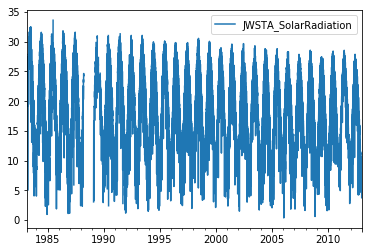

In [19]:
prep = copy.deepcopy(data[['Solar']])
prep = threC(prep,'SolarRadiation')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
siteList = pd.unique(prep.columns) 
ready_columns =  ['JWSTA_SolarRadiation'] #

nan_values = np.nan*np.ones([len(indexUnique),len(siteList)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(siteList)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site] #
    
    for j in np.arange(len(tab)):  
        if  data['QSolar'][tab.index[j]] =='G':   #only keep the data when Quality is good  
            df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
            
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()
SolarRadiation.head()

### 5. RelativeHumidity

In [20]:
data = pd.read_csv('https://jornada.nmsu.edu/sites/jornada.nmsu.edu/files/data_files/JornadaStudy_126_lter_weather_station_climate_daily_data_0.csv',
                    header = 0,parse_dates = True,index_col = 'Date',infer_datetime_format = True,skiprows=50)
data.head(3)

MaxAirTemp  MinAirTemp  AvgAirTemp  Solar  Ppt  MaxRH  MinRH  \
Date                                                                       
1983-03-01       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   
1983-03-02         2.9        -2.0        0.31   -9.0  0.0   -9.0   -9.0   
1983-03-03       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   

            VcWndMg  VcWndDir  AvgWndSpd  ...  QPpt  QMaxRH  QMinRH  QVcWndMg  \
Date                                      ...                                   
1983-03-01     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-02     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-03     -9.0        -9       -9.0  ...     G       M       M         M   

            QVcWndDir  QAvgWndSpd QMaxWndSpd QAvg5cmSoil QAvg20cmSoil  \
Date                                                                    
1983-03-01          M           M          M           M            M   
1983-03-02          M           M          M           M            M   
1983-03-03          M           M          M           M            M   

           QDewPoint  
Date                  
1983-03-01         M  
1983-03-02         M  
1983-03-03         M  

[3 rows x 31 columns]

MaxRH
MinRH


JWSTA_RelativeHumidity_max  JWSTA_RelativeHumidity_min
1983-03-01                         NaN                         NaN
1983-03-02                         NaN                         NaN
1983-03-03                         NaN                         NaN
1983-03-04                         NaN                         NaN
1983-03-05                        64.6                        27.8

<Figure size 720x288 with 0 Axes>

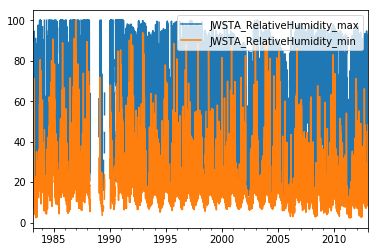

In [21]:
prep = copy.deepcopy(data[['MaxRH','MinRH']])
prep = threC(prep,'RelativeHumidity')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
siteList = pd.unique(prep.columns) #siteList = pd.unique(prep['SiteName'])   #
ready_columns =  ['JWSTA_RelativeHumidity_max','JWSTA_RelativeHumidity_min']

nan_values = np.nan*np.ones([len(indexUnique),len(siteList)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(siteList)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site] 
    
    for j in np.arange(len(tab)): 
        if i ==0:
            if  data['QMaxRH'][tab.index[j]]=='G':   #only keep the data when Quality is good   
                df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
        if i==1:
            if  data['QMinRH'][tab.index[j]] =='G':   #only keep the data when Quality is good   
                df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
            
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()
RelativeHumidity.head()

### 6. WindDirection

In [22]:
data = pd.read_csv('https://jornada.nmsu.edu/sites/jornada.nmsu.edu/files/data_files/JornadaStudy_126_lter_weather_station_climate_daily_data_0.csv',
                    header = 0,parse_dates = True,index_col = 'Date',infer_datetime_format = True,skiprows=50)
data.head(3) 

MaxAirTemp  MinAirTemp  AvgAirTemp  Solar  Ppt  MaxRH  MinRH  \
Date                                                                       
1983-03-01       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   
1983-03-02         2.9        -2.0        0.31   -9.0  0.0   -9.0   -9.0   
1983-03-03       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   

            VcWndMg  VcWndDir  AvgWndSpd  ...  QPpt  QMaxRH  QMinRH  QVcWndMg  \
Date                                      ...                                   
1983-03-01     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-02     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-03     -9.0        -9       -9.0  ...     G       M       M         M   

            QVcWndDir  QAvgWndSpd QMaxWndSpd QAvg5cmSoil QAvg20cmSoil  \
Date                                                                    
1983-03-01          M           M          M           M            M   
1983-03-02          M           M          M           M            M   
1983-03-03          M           M          M           M            M   

           QDewPoint  
Date                  
1983-03-01         M  
1983-03-02         M  
1983-03-03         M  

[3 rows x 31 columns]

VcWndDir


JWSTA_WindDirection
1983-03-01                  NaN
1983-03-02                  NaN
1983-03-03                  NaN
1983-03-04                  NaN
1983-03-05                 91.0

<Figure size 720x288 with 0 Axes>

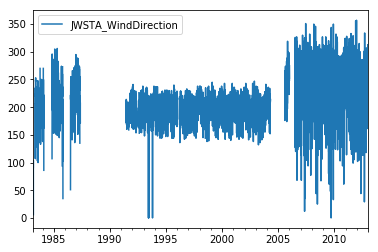

In [23]:
prep = copy.deepcopy(data[['VcWndDir']])
prep = threC(prep,'WindDirection')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
siteList = pd.unique(prep.columns) #siteList = pd.unique(prep['SiteName'])   #
ready_columns =  ['JWSTA_WindDirection'] #

nan_values = np.nan*np.ones([len(indexUnique),len(siteList)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(siteList)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site] #
    
    for j in np.arange(len(tab)):
        if data['QVcWndDir'][tab.index[j]] =='G':   #only keep the data when Quality is good   
                df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 

            
WindDirection = copy.deepcopy(df)
WindDirection.plot()
WindDirection.head()

### 7. WindSpeed

In [24]:
data = pd.read_csv('https://jornada.nmsu.edu/sites/jornada.nmsu.edu/files/data_files/JornadaStudy_126_lter_weather_station_climate_daily_data_0.csv',
                    header = 0,parse_dates = True,index_col = 'Date',infer_datetime_format = True,skiprows=50)
data.head(3) 

MaxAirTemp  MinAirTemp  AvgAirTemp  Solar  Ppt  MaxRH  MinRH  \
Date                                                                       
1983-03-01       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   
1983-03-02         2.9        -2.0        0.31   -9.0  0.0   -9.0   -9.0   
1983-03-03       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   

            VcWndMg  VcWndDir  AvgWndSpd  ...  QPpt  QMaxRH  QMinRH  QVcWndMg  \
Date                                      ...                                   
1983-03-01     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-02     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-03     -9.0        -9       -9.0  ...     G       M       M         M   

            QVcWndDir  QAvgWndSpd QMaxWndSpd QAvg5cmSoil QAvg20cmSoil  \
Date                                                                    
1983-03-01          M           M          M           M            M   
1983-03-02          M           M          M           M            M   
1983-03-03          M           M          M           M            M   

           QDewPoint  
Date                  
1983-03-01         M  
1983-03-02         M  
1983-03-03         M  

[3 rows x 31 columns]

AvgWndSpd


JWSTA_WindSpeed
1983-03-01              NaN
1983-03-02              NaN
1983-03-03              NaN
1983-03-04              NaN
1983-03-05             10.1

<Figure size 720x288 with 0 Axes>

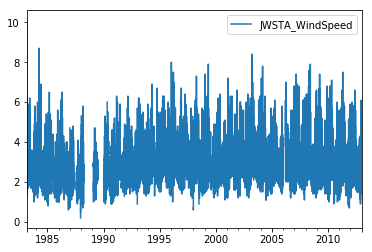

In [25]:
prep = copy.deepcopy(data[['AvgWndSpd']])
prep = threC(prep,'WindSpeed')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
siteList = pd.unique(prep.columns) #siteList = pd.unique(prep['SiteName'])   #
ready_columns =  ['JWSTA_WindSpeed'] #

nan_values = np.nan*np.ones([len(indexUnique),len(siteList)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(siteList)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site] #
    
    for j in np.arange(len(tab)):  
        if  data['QAvgWndSpd'][tab.index[j]]=='G':   #only keep the data when Quality is good   
                df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 

WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head()

### 12. SoilTemperature

In [26]:
data = pd.read_csv('https://jornada.nmsu.edu/sites/jornada.nmsu.edu/files/data_files/JornadaStudy_126_lter_weather_station_climate_daily_data_0.csv',
                    header = 0,parse_dates = True,index_col = 'Date',infer_datetime_format = True,skiprows=50)
data.head(3) 

MaxAirTemp  MinAirTemp  AvgAirTemp  Solar  Ppt  MaxRH  MinRH  \
Date                                                                       
1983-03-01       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   
1983-03-02         2.9        -2.0        0.31   -9.0  0.0   -9.0   -9.0   
1983-03-03       -99.0       -99.0      -99.00   -9.0  0.0   -9.0   -9.0   

            VcWndMg  VcWndDir  AvgWndSpd  ...  QPpt  QMaxRH  QMinRH  QVcWndMg  \
Date                                      ...                                   
1983-03-01     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-02     -9.0        -9       -9.0  ...     G       M       M         M   
1983-03-03     -9.0        -9       -9.0  ...     G       M       M         M   

            QVcWndDir  QAvgWndSpd QMaxWndSpd QAvg5cmSoil QAvg20cmSoil  \
Date                                                                    
1983-03-01          M           M          M           M            M   
1983-03-02          M           M          M           M            M   
1983-03-03          M           M          M           M            M   

           QDewPoint  
Date                  
1983-03-01         M  
1983-03-02         M  
1983-03-03         M  

[3 rows x 31 columns]

Avg5cmSoil
Avg20cmSoil


JWSTA_SoilTemperature_5cm  JWSTA_SoilTemperature_20cm
1983-03-01                        NaN                         NaN
1983-03-02                        NaN                         NaN
1983-03-03                        NaN                         NaN
1983-03-04                        NaN                         NaN
1983-03-05                        NaN                         NaN

<Figure size 720x288 with 0 Axes>

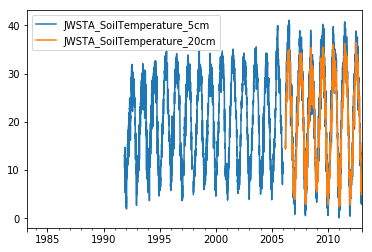

In [27]:
prep = copy.deepcopy(data[['Avg5cmSoil','Avg20cmSoil']])
prep = threC(prep,'SoilMoisture')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
siteList = pd.unique(prep.columns) #siteList = pd.unique(prep['SiteName'])   #
ready_columns =  ['JWSTA_SoilTemperature_5cm','JWSTA_SoilTemperature_20cm']

nan_values = np.nan*np.ones([len(indexUnique),len(siteList)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(siteList)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site] #
    
    for j in np.arange(len(tab)):  
        if i ==0:
            if  data['QAvg5cmSoil'][tab.index[j]] =='G':   #only keep the data when Quality is good   
                df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
        if i==1:
            if  data['QAvg20cmSoil'][tab.index[j]] =='G':   #only keep the data when Quality is good   
                df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
            
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()
SoilTemperature.head()

# Results

In [28]:
# Put all the tables to the same date format
# data_soil.index= pd.to_datetime(data_soil.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data.index= pd.to_datetime(data.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data_lwr.index= pd.to_datetime(data_lwr.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S

# Bring them together
result1 = pd.concat([Discharge,Precipitation, AirTemperature,SolarRadiation,
                     RelativeHumidity,WindDirection,WindSpeed,SoilTemperature], axis=1,
                    join='outer')


In [29]:
result1.index.rename('DateTime', inplace = True)
result1.head(5)# All data are from HF001 met site

SaltCreek_Discharge  JWSTA_Precipitation  JWSTA_AirTemperature  \
DateTime                                                                     
1983-03-01                  NaN                  0.0                   NaN   
1983-03-02                  NaN                  0.0                  0.31   
1983-03-03                  NaN                  0.0                   NaN   
1983-03-04                  NaN                  0.0                  8.62   
1983-03-05                  NaN                  0.0                  8.91   

            JWSTA_SolarRadiation  JWSTA_RelativeHumidity_max  \
DateTime                                                       
1983-03-01                   NaN                         NaN   
1983-03-02                   NaN                         NaN   
1983-03-03                   NaN                         NaN   
1983-03-04                   NaN                         NaN   
1983-03-05                 19.97                        64.6   

            JWSTA_RelativeHumidity_min  JWSTA_WindDirection  JWSTA_WindSpeed  \
DateTime                                                                       
1983-03-01                         NaN                  NaN              NaN   
1983-03-02                         NaN                  NaN              NaN   
1983-03-03                         NaN                  NaN              NaN   
1983-03-04                         NaN                  NaN              NaN   
1983-03-05                        27.8                 91.0             10.1   

            JWSTA_SoilTemperature_5cm  JWSTA_SoilTemperature_20cm  
DateTime                                                           
1983-03-01                        NaN                         NaN  
1983-03-02                        NaN                         NaN  
1983-03-03                        NaN                         NaN  
1983-03-04                        NaN                         NaN  
1983-03-05                        NaN                         NaN

In [30]:
# Write data to csv for further inspection
result1.to_csv('1_JornadaBasin_Download_Aggregation_Daily.csv', sep=',')